In [1]:
import tensorflow as tf
import numpy as np

n_steps, n_features = (28, 28)
n_neurons = 150
n_classes = 10

lr = 1e-3  # Learning rate

X = tf.placeholder(tf.float32, [None, n_steps, n_features])  # Samples
y = tf.placeholder(tf.int32, [None])  # Labels

# RNN layers
basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
outpus, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

# Classifier layers
logits = tf.layers.dense(states, n_classes)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)

# Cost module
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [2]:
preprocess = lambda x: x.astype(np.float32).reshape(-1, 28*28) / 255.0

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = preprocess(X_train)
X_test = preprocess(X_test)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = X_train.reshape((-1, n_steps, n_features))
X_test = X_test.reshape((-1, n_steps, n_features))

n_validation = 5000
X_valid, X_train = X_train[:n_validation], X_train[n_validation:]
y_valid, y_train = y_train[:n_validation], y_train[n_validation:]

In [4]:
def shuffle_batch(X, y, batch_size=150):
    n_samples = len(X)
    rand_idx = np.random.permutation(n_samples)
    n_batches = n_samples // batch_size
    for batch_idx in np.array_split(rand_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [5]:
import time

n_epochs = 10

history_acc_train = []
history_acc_val = []

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        start = time.time()
        acc_batch = []
        for X_batch, y_batch in shuffle_batch(X_train, y_train):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            acc_batch.append(accuracy.eval(feed_dict={X: X_batch, y: y_batch}))
        end = time.time()
        print('epoch={}, time={:1.5f} s'.format(epoch, (end-start)))
        acc_train = np.mean(acc_batch, axis=0)
        acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        history_acc_train.append(acc_train)
        history_acc_val.append(acc_val)
        print('acc_train={:1.5f}, acc_val={:1.5f}'.format(acc_train, acc_val))

epoch=0, time=6.05780 s
acc_train=0.85679, acc_val=0.92980
epoch=1, time=5.77460 s
acc_train=0.94643, acc_val=0.94400
epoch=2, time=5.90218 s
acc_train=0.95648, acc_val=0.95680
epoch=3, time=5.94113 s
acc_train=0.96638, acc_val=0.96600
epoch=4, time=5.90054 s
acc_train=0.97025, acc_val=0.97060
epoch=5, time=5.90339 s
acc_train=0.97546, acc_val=0.96600
epoch=6, time=5.75915 s
acc_train=0.97637, acc_val=0.97140
epoch=7, time=5.72848 s
acc_train=0.97734, acc_val=0.96600
epoch=8, time=5.71836 s
acc_train=0.98053, acc_val=0.97300
epoch=9, time=5.72302 s
acc_train=0.98191, acc_val=0.96620


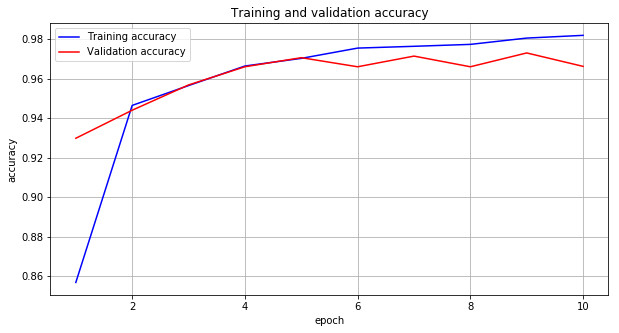

In [7]:
import matplotlib.pyplot as plt

epochs = np.arange(n_epochs) + 1

plt.figure(figsize=(10,5))
plt.title('Training and validation accuracy')
plt.plot(epochs, history_acc_train, 'b', label='Training accuracy')
plt.plot(epochs, history_acc_val, 'r', label='Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend()
plt.show()

In [9]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [10]:
reset_graph()

n_steps, n_features = (28,28)
n_classes = 10

lr = 1e-3

X = tf.placeholder(tf.float32, [None, n_steps, n_features])
y = tf.placeholder(tf.int32, [None])

In [11]:
n_neurons = 100
n_layers = 3

layers = [tf.nn.rnn_cell.BasicRNNCell(
            num_units=n_neurons,
            activation=tf.nn.relu) for n in range(n_layers)]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

states_concat = tf.concat(axis=1, values=states)
logits = tf.layers.dense(states_concat, n_classes)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [12]:
n_epochs = 30
batch_size = 150

history_acc_train = []
history_acc_val = []

saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        start = time.time()
        acc_batch = []
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            acc_batch.append(accuracy.eval(feed_dict={X: X_batch, y: y_batch}))
        end = time.time()
        acc_train = np.mean(acc_batch)
        acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        history_acc_train.append(acc_train)
        history_acc_val.append(acc_val)
        print('epoch={}, time={:3.3f}'.format(epoch, end-start))
        print('acc_train={:1.5f}, acc_val={:1.5f}'.format(acc_train, acc_val))
        print('states_concat shape=', states_concat.eval(feed_dict={X:X_batch, y:y_batch}).shape)
    saver.save(sess, './multi_cell_rnn')

epoch=0, time=8.410
acc_train=0.82140, acc_val=0.93800
states_concat shape= (150, 300)
epoch=1, time=8.235
acc_train=0.95329, acc_val=0.96060
states_concat shape= (150, 300)
epoch=2, time=8.217
acc_train=0.96764, acc_val=0.96360
states_concat shape= (150, 300)
epoch=3, time=8.206
acc_train=0.97497, acc_val=0.96840
states_concat shape= (150, 300)
epoch=4, time=8.221
acc_train=0.97898, acc_val=0.97420
states_concat shape= (150, 300)
epoch=5, time=8.210
acc_train=0.98238, acc_val=0.97040
states_concat shape= (150, 300)
epoch=6, time=8.270
acc_train=0.98444, acc_val=0.97440
states_concat shape= (150, 300)
epoch=7, time=8.217
acc_train=0.98516, acc_val=0.97800
states_concat shape= (150, 300)
epoch=8, time=8.206
acc_train=0.98756, acc_val=0.98300
states_concat shape= (150, 300)
epoch=9, time=8.218
acc_train=0.98907, acc_val=0.97520
states_concat shape= (150, 300)
epoch=10, time=8.212
acc_train=0.98934, acc_val=0.98040
states_concat shape= (150, 300)
epoch=11, time=8.214
acc_train=0.99069, ac

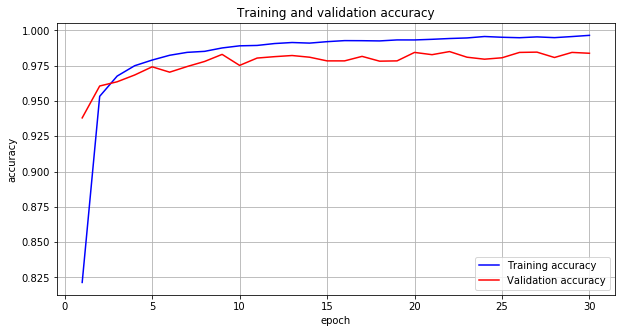

In [13]:
epochs = np.arange(n_epochs) + 1

plt.figure(figsize=(10,5))
plt.title('Training and validation accuracy')
plt.plot(epochs, history_acc_train, 'b', label='Training accuracy')
plt.plot(epochs, history_acc_val, 'r', label='Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend()
plt.show()